In [64]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

ibmqfactory.load_account:WARNING:2023-05-30 11:29:56,844: Credentials are already in use. The existing account in the session will be replaced.


In [65]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[i + 1] - 1) for i in range(n - 1)])
def effective_hem(size, J):
    hem = np.zeros((2**size, 2**size))
    for i in range(2**size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1)**int(i) for i in binary]
        hem[i,i] = h(size, J, Z)
    return hem
#print(effective_hem(4,[1,1,1]))

[]


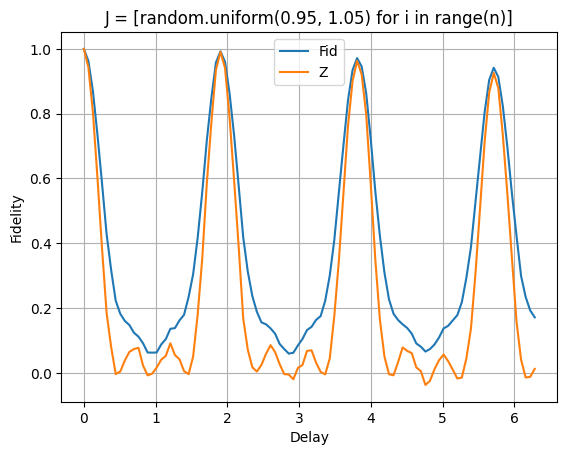

In [66]:
from scipy.linalg import expm
import random
res = []
delay = np.linspace(0,2*np.pi,100)
n = 4
fid = []
Z = []
Zi = [[] for _ in range(n)] # Create a list of lists to store the expectation values for each qubit

J = [random.uniform(0.8, 1.2) for _ in range(n-1)]
#J = [0.8, np.sqrt(3)]
for t in delay:
    #qr = QuantumRegister(n)
    #cr = ClassicalRegister(n)
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)

    U = expm((-1j*t)*effective_hem(n,J))
    U = qi.Operator(U)

    qc.unitary(U, [i for i in range(n)])

    for i in range(n):
        qc.h(i)
    qc.measure_all()
    #qc.measure(qr[1],cr[1])

    #Simulator
    qcomp = Aer.get_backend("qasm_simulator")
    result = qiskit.execute(qc, Aer.get_backend('qasm_simulator'), shots=8000).result()
    fid.append(result.get_counts().get('0'*n,0)/8000)
    res.append(result.get_counts())

    z_expectation_value = 0
    for outcome, count in result.get_counts().items():
        # Calculate parity (1 for even parity, -1 for odd parity)
        parity = (-1) ** outcome.count('1')
        probability = count / sum(result.get_counts().values())
        z_expectation_value += parity * probability
    Z.append(z_expectation_value)



print(Zi[0])
plt.grid()
plt.ylabel('Fidelity')
plt.xlabel('Delay')
plt.title('J = [random.uniform(0.95, 1.05) for i in range(n)]')
plt.plot(delay,fid, label = 'Fid')
plt.plot(delay,Z, label = 'Z')
plt.legend()

[0.8059181655054666, 0.8254112936596725, 0.840404066579511]
0.7615982190520711


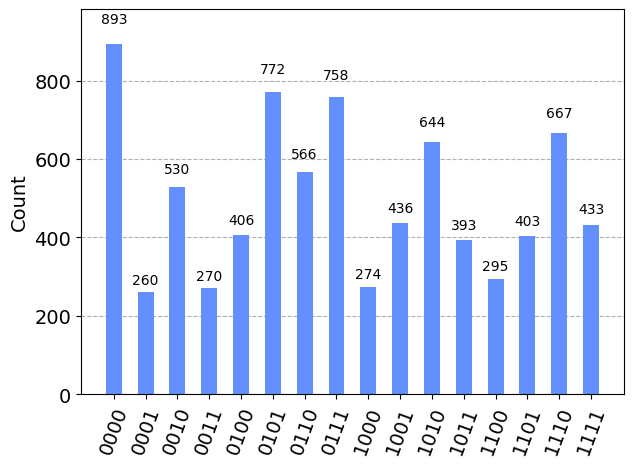

In [67]:
#Plots qiskit histogram:
print(J)
print(delay[12])
t = delay[6]
from qiskit.visualization import plot_histogram
plot_histogram(res[12])


In [68]:
from imp import reload
import CalculateCrossTalk
reload(CalculateCrossTalk)
print(CalculateCrossTalk.one_dim(t,res[6], n))

7014.644291667927
[0.82214576 0.79330204 0.83833928]


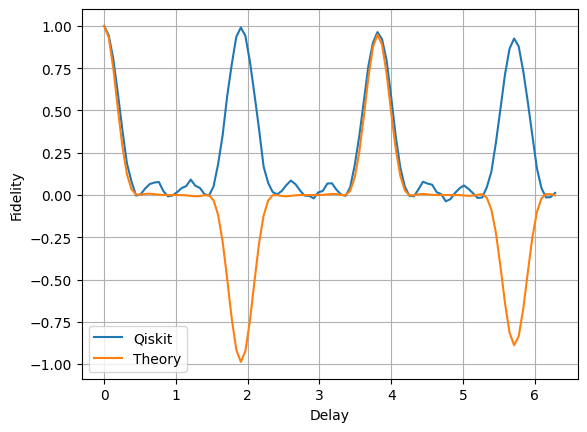

In [69]:
def func(js,t):
    H = effective_hem(n,js)
    y = 1
    for i in range(n**2-1):
        y *= np.cos(0.5*H[i][i]*t)
    return y
Y = [func(J,t) for t in delay]
plt.grid()
plt.ylabel('Fidelity')
plt.xlabel('Delay')
plt.plot(delay,Z, label = 'Qiskit')
plt.plot(delay,Y, label = 'Theory')
plt.legend()

Fitted coefficients:  [1.23045925 1.64671261 0.4140554 ]


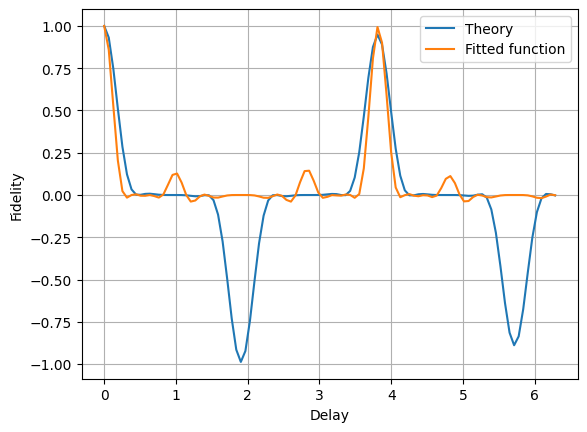

In [71]:
from scipy.optimize import curve_fit

# Define the function that you want to fit.
def func(t, *js):
    H = effective_hem(n, js)
    y = 1
    for i in range(n**2-1):
        y *= np.cos(0.5*H[i][i]*t)
    return y

# Initial guess for js
# Here I'm assuming that js is a list of the same size as delay.
# If that's not the case, you should provide an appropriate initial guess.
initial_js = np.ones(n-1)

# Fit your function to the data
popt, pcov = curve_fit(func, delay, Z, p0=initial_js, bounds=(0,2))

# Print the coefficients
print("Fitted coefficients: ", popt)

# Generate Y values for the fitted function
Y_fitted = [func(t, *popt) for t in delay]

# Plot the data, the original function, and the fitted function
plt.grid()
plt.ylabel('Fidelity')
plt.xlabel('Delay')
#plt.plot(delay, Z, label='Qiskit')
plt.plot(delay, Y, label='Theory')
plt.plot(delay, Y_fitted, label='Fitted function')
plt.legend()
